In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from timeit import timeit
from IPython.display import display
import matplotlib
# matplotlib.use("pgf")
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from collections import Counter
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import cohen_kappa_score, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from joblib import dump, load
from imblearn.under_sampling import RandomUnderSampler
import shap
import seaborn as sns

In [2]:
from compiledataset import load_dataset, compile_dataset

PATH = "/home/hampus/miun/master_thesis/Datasets"

datasets = {}

# dataset: pd.DataFrame = load_dataset(PATH + "/ORNL", "data_a.csv")
# dataset["remarks"] = "No DLC available"
# datasets["ROAD"] = dataset.to_dict("records")

dataset: pd.DataFrame = load_dataset(PATH + "/Survival", "data.csv")
dataset["remarks"] = "-"
datasets["Survival"] = dataset.to_dict("records")

# dataset: pd.DataFrame = load_dataset(PATH + "/Hisingen", "data.csv")
# dataset["remarks"] = "-"
# datasets["Hisingen"] = dataset.to_dict("records")


df = compile_dataset(datasets)
df.drop(columns=["data", "data_dec", "ID", "DLC", "t"], inplace=True, errors="ignore")
# df.drop(columns=["d0", "d1", "d2", "d3", "d4", "d5", "d6", "d7"], inplace=True, errors="ignore")

dataset = None # Release memory, as it isn't used for now
datasets = None

display(df)

,d0,d1,d2,d3,d4,d5,d6,d7,dcs,dcs_ID,dt,dt_ID,dt_data,name,class,dataset,type,Label
0,21,30,30,48,0,143,123,44,0.369422,0.078324,0.000444,0.009978,0.724212,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
1,64,0,118,29,204,4,227,0,0.453125,0.025104,0.000232,0.009977,0.045600,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
2,20,0,0,0,0,0,0,0,0.343750,0.000896,0.000248,0.009981,0.009991,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
3,12,185,127,20,17,32,0,20,0.328125,0.008395,0.000234,0.009978,0.047617,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
4,216,0,0,140,0,0,0,0,0.375000,0.038187,0.000241,0.009978,0.036785,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535036,254,69,0,0,0,60,0,0,0.500000,0.000000,0.000239,0.010094,0.010094,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
535037,25,31,30,48,0,142,99,30,0.437500,0.046875,0.000235,0.010094,12.029791,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
535038,32,0,113,29,204,4,227,0,0.484375,0.015625,0.000234,0.010092,0.039899,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
535039,142,178,127,20,17,32,0,20,0.453125,0.000000,0.000232,0.010092,0.010092,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0


In [3]:
from sklearn.preprocessing import StandardScaler, RobustScaler

feature_columns= list(set(df.columns.to_list()).difference(["name", "class", "dataset", "type", "Label"]))

for col in feature_columns:
    scaler = RobustScaler().fit(df.loc[df["Label"] == 0, df.columns == col])
    df.loc[:, df.columns ==col] = scaler.transform(df.loc[:, df.columns == col])

display(df)

,d0,d1,d2,d3,d4,d5,d6,d7,dcs,dcs_ID,dt,dt_ID,dt_data,name,class,dataset,type,Label
0,0.052083,-0.029851,0.769231,0.379630,-0.060870,0.913386,13.666667,0.733333,0.091860,0.602552,12.635966,-0.032347,1.032490,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
1,0.500000,-0.477612,3.025641,0.203704,1.713043,-0.181102,25.222222,0.000000,0.857143,-0.078674,-0.626866,-0.033724,0.008422,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
2,0.041667,-0.477612,0.000000,-0.064815,-0.060870,-0.212598,0.000000,0.000000,-0.142857,-0.388528,0.373134,-0.030027,-0.045314,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
3,-0.041667,2.283582,3.256410,0.120370,0.086957,0.039370,0.000000,0.333333,-0.285714,-0.292542,-0.492537,-0.032380,0.011465,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
4,2.083333,-0.477612,0.000000,1.231481,-0.060870,-0.212598,0.000000,0.000000,0.142857,0.088797,-0.074627,-0.032380,-0.004880,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535036,2.479167,0.552239,0.000000,-0.064815,-0.060870,0.259843,0.000000,0.000000,1.285714,-0.400000,-0.179104,0.064176,-0.045159,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
535037,0.093750,-0.014925,0.769231,0.379630,-0.060870,0.905512,11.000000,0.500000,0.714286,0.200000,-0.447761,0.063978,18.093316,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
535038,0.166667,-0.477612,2.897436,0.203704,1.713043,-0.181102,25.222222,0.000000,1.142857,-0.200000,-0.492537,0.062388,-0.000181,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
535039,1.312500,2.179104,3.256410,0.120370,0.086957,0.039370,0.000000,0.333333,0.857143,-0.400000,-0.626866,0.062388,-0.045162,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0


In [4]:
# Stratify on the sub-dataset
X_train = df.drop(columns="Label")
y_train = df["Label"]

df = None # Release memory

# Split dataset into training and test data, stratify by the type of attack
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0, shuffle=True, stratify=X_train["name"])

In [5]:
X_train.drop(columns=["type", "dataset", "name", "class"], inplace=True)
X_test.drop(columns=["type", "dataset", "name", "class"], inplace=True)

In [6]:
# X_train = df.loc[df["Label"] == 0]
# X_test = df.loc[df["Label"] == 1]
X_train_normal = X_train.loc[y_train[y_train == 0].index]
X_train_anomaly = X_train.loc[y_train[y_train == 1].index]

X_test_normal = X_test.loc[y_test[y_test == 0].index]
X_test_anomaly = X_test.loc[y_test[y_test == 1].index]

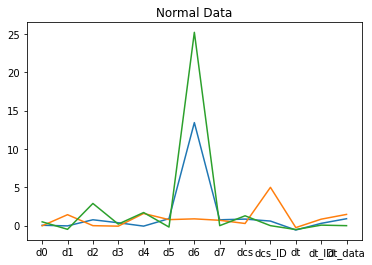

In [7]:
plt.plot(X_train_normal.iloc[0])
plt.plot(X_train_normal.iloc[1])
plt.plot(X_train_normal.iloc[2])
plt.title("Normal Data")
plt.show()

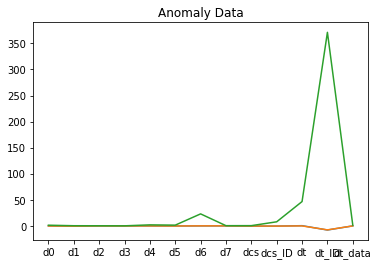

In [8]:
plt.plot(X_train_anomaly.iloc[0])
plt.plot(X_train_anomaly.iloc[1])
plt.plot(X_train_anomaly.iloc[2])
plt.title("Anomaly Data")
plt.show()

Autoencoder

In [10]:
import keras
from keras import Sequential, layers, callbacks
from keras.models import Model

class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Sequential([ # 13 input features
            layers.Dense(10, activation="relu"),
            layers.Dense(7, activation="relu"),
            layers.Dense(5, activation="relu"),
            layers.Dense(2, activation="relu")
        ])
        self.decoder = Sequential([
            layers.Dense(5, activation="relu"),
            layers.Dense(7, activation="relu"),
            layers.Dense(10, activation="relu"),
            layers.Dense(13, activation="sigmoid")
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# input_img = keras.Input(shape=(6,))
# encoded = layers.Dense(4, activation='relu')(input_img)
# encoded = layers.Dense(2, activation='relu')(encoded)
# encoded = layers.Dense(1, activation='relu')(encoded)

# decoded = layers.Dense(2, activation='relu')(encoded)
# decoded = layers.Dense(4, activation='relu')(decoded)
# decoded = layers.Dense(6, activation='sigmoid')(decoded)

# autoencoder = keras.Model(input_img, decoded)
# autoencoder.compile(optimizer='adam', loss='msle')

model = AutoEncoder()

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

model.compile(optimizer='adam', loss="mean_squared_error")
history = model.fit(X_train_normal, X_train_normal, epochs=25, batch_size=120,
    validation_data=(X_test_normal, X_test_normal),
    shuffle=True,
    callbacks=[early_stopping]
)

# history = autoencoder.fit(X_train, X_train,
#     epochs=100,
#     batch_size=256,
#     shuffle=True,
#     validation_data=(X_test, X_test),
#     callbacks=[early_stop]
# ).history

Epoch 1/25
2734/2734 [==============================] - 4s 1ms/step - loss: 218.5645 - val_loss: 221.7414
Epoch 2/25
2734/2734 [==============================] - 3s 1ms/step - loss: 218.4603 - val_loss: 221.7177
Epoch 3/25
2734/2734 [==============================] - 3s 1ms/step - loss: 218.4470 - val_loss: 221.7107
Epoch 4/25
2734/2734 [==============================] - 3s 1ms/step - loss: 218.4348 - val_loss: 221.7001
Epoch 5/25
2734/2734 [==============================] - 3s 1ms/step - loss: 218.4300 - val_loss: 221.6951
Epoch 6/25
2734/2734 [==============================] - 3s 1ms/step - loss: 218.4272 - val_loss: 221.6949
Epoch 7/25
2734/2734 [==============================] - 3s 1ms/step - loss: 218.4206 - val_loss: 221.6934
Epoch 8/25
2734/2734 [==============================] - 3s 1ms/step - loss: 218.4187 - val_loss: 221.6850
Epoch 9/25
2734/2734 [==============================] - 4s 1ms/step - loss: 218.4225 - val_loss: 221.7061
Epoch 10/25
2734/2734 [=======================

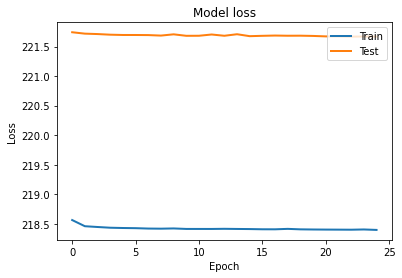

In [11]:
plt.plot(history.history['loss'], linewidth=2, label='Train')
plt.plot(history.history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [12]:
X_test_pred = model.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_test})

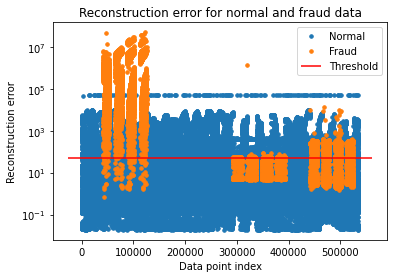

In [13]:
threshold_fixed = 50
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
ax.set_yscale('log')
plt.title("Reconstruction error for normal and fraud data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

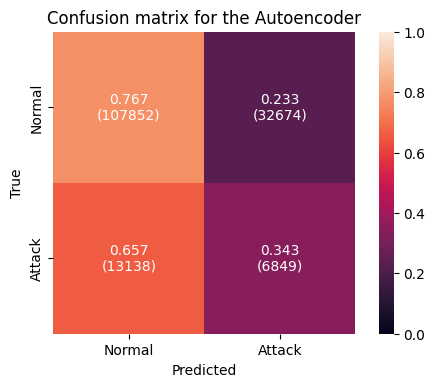

Testing F1:  0.7508(+/- 0.0000)
Kappa score:  0.0776(+/- 0.0000)


In [ ]:
from plot_tools import plot_confusion_matrix

threshold_fixed = 52
y_pred = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] = y_pred

plot_confusion_matrix(y_test, y_pred, "Confusion matrix for the Autoencoder")

f1_scores = f1_score(y_test, y_pred, average='weighted')
print("Testing F1:  %0.4f(+/- %0.4f)" % (f1_scores.mean(), f1_scores.std()))

kappa_scores = cohen_kappa_score(y_test, y_pred)
print("Kappa score:  %0.4f(+/- %0.4f)" % (kappa_scores.mean(), kappa_scores.std()))

# # print Accuracy, precision and recall
# print(" Accuracy: ",accuracy_score(error_df['True_class'], error_df['pred']))
# print(" Recall: ",recall_score(error_df['True_class'], error_df['pred']))
# print(" Precision: ",precision_score(error_df['True_class'], error_df['pred']))